<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Contextual-Bandit" data-toc-modified-id="Contextual-Bandit-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Contextual Bandit</a></span><ul class="toc-item"><li><span><a href="#Replay-Estimator" data-toc-modified-id="Replay-Estimator-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Replay Estimator</a></span></li><li><span><a href="#Direct-Method-Estimator" data-toc-modified-id="Direct-Method-Estimator-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Direct Method Estimator</a></span></li><li><span><a href="#Inverse-Propensity-Estimator" data-toc-modified-id="Inverse-Propensity-Estimator-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Inverse Propensity Estimator</a></span></li></ul></li></ul></div>

In [1]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib,lightgbm

Ethen 2019-03-03 16:42:37 

CPython 3.6.4
IPython 6.4.0

numpy 1.14.2
pandas 0.23.4
sklearn 0.20.2
matplotlib 2.2.3


# Contextual Bandit

- https://github.com/smn-ailab/ysaito-qiita
- https://github.com/colby-j-wise/Multi-Arm_Contextual_Bandit_Problem/blob/master/LinUCB.ipynb
- http://www.cs.columbia.edu/~jebara/6998/hw2.pdf
- http://www.cs.columbia.edu/~jebara/6998/
- http://manikvarma.org/downloads/XC/XMLRepository.html
- https://arxiv.org/pdf/1003.0146.pdf
- https://arxiv.org/pdf/1003.5956.pdf
- https://arxiv.org/pdf/1103.4601v2.pdf
- http://john-maxwell.com/post/2017-03-17/

In [2]:
def get_data(file_path):
    """
    Read in CSV data file and remove 'timestamp' column.

    Parameters
    ----------
    file_path : str

    Returns
    -------
    data : pd.Dataframe
        DataFrame that consists of action, reward & context vectors.
    """
    data = pd.read_csv(file_path, sep=' ', header=None)
    return data.loc[:, :101]


path = 'dataset.txt'
data = get_data(path)
print('dimension: ', data.shape)
data.head()

dimension:  (10000, 102)


,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,2,0,5,0,0,37,6,0,0,0,...,0,0,1,3,0,0,17,30,4,0
1,8,0,1,3,36,0,0,0,0,0,...,0,0,3,0,1,5,1,0,0,10
2,5,0,3,0,0,0,0,0,0,0,...,0,0,0,0,23,0,11,3,0,0
3,4,0,77,0,0,13,0,0,0,0,...,0,5,0,0,0,2,4,0,0,0
4,2,1,43,0,2,44,1,0,0,0,...,0,0,0,0,0,0,0,13,0,0


- The first column in the dataset is the action that was performed. This is a value $a_t \in \{1, ..., 10\}$
- The second column is a binary value indicating if a reward was obtained, $y_t \in \{0, 1\}$
- The remaining 100 columns are the context which is a represented as vector $x_t \in \mathbb{R}^{100}$

In [3]:
data.loc[:, 0].value_counts()

4     1047
7     1035
1     1020
5     1005
8      999
9      988
10     987
2      982
3      974
6      963
Name: 0, dtype: int64

In [4]:
contexts = data.loc[:, 2:].values
actions = data.loc[:, 0].values - 1
rewards = data.loc[:, 1].values
rewards

array([0, 0, 0, ..., 1, 0, 0])

In [5]:
class LinearUCBArm:

    def __init__(self, arm_idx, n_features, alpha=0.1):
        self.alpha = alpha
        self.arm_idx = arm_idx
        self.n_features = n_features

        self.A_ = np.identity(n_features)
        self.b_ = np.zeros(n_features)

    def get_ucb(self, x):
        # we can cache the inverse and only update the cache
        # whenever there's a update if the inverse is too expensive
        A_inv = np.linalg.inv(self.A_)
        self.theta_ = A_inv @ self.b_
        self.stdev_ = np.sqrt(x.T @ A_inv @ x)
        self.ucb_ = self.theta_ @ x + self.alpha + self.stdev_
        return self.ucb_

    def update_arm(self, x, reward):
        x = x.reshape((1, -1))
        self.A_ += x.T @ x
        self.b_ += reward * x.ravel()
        return self

In [6]:
arm_idx = 1
data_idx = 1
n_features = 100
linear_ucb_arm = LinearUCBArm(arm_idx, n_features)

context = contexts[data_idx]
reward = rewards[data_idx]
ucb = linear_ucb_arm.get_ucb(context)
linear_ucb_arm.update_arm(context, reward)
ucb

89.9443097808648

In [7]:
class LinearUCB:
    # TODO warm up?

    def __init__(self, n_arms, n_features, alpha=0.1):
        self.alpha = alpha
        self.n_arms = n_arms
        self.n_features = n_features
        self.arms_ = self._init_arms()
        self.counts_ = np.zeros(n_arms, dtype=np.int)
  
    def _init_arms(self):
        return [
            LinearUCBArm(arm_idx, self.n_features, self.alpha)
            for arm_idx in range(self.n_arms)
        ]

    def get_ucbs(self, x):
        return [arm.get_ucb(x) for arm in self.arms_]

    def choose_arm(self, x):
        ucbs = self.get_ucbs(x)
        return np.argmax(ucbs)
    
    def update_arm(self, x, chosen_arm, reward):
        self.arms_[chosen_arm].update_arm(x, reward)
        self.counts_[chosen_arm] += 1
        return self


n_arms = 10
n_features = 100
policy = LinearUCB(n_arms, n_features)
policy.arms_

## Replay Estimator

In [8]:
from tqdm import trange


class ReplayEstimator:
    
    def __init__(self, policy):
        self.policy = policy

    def estimate(self, contexts: np.ndarray, actions: np.ndarray, rewards: np.ndarray):
        policy = self.policy
        n_rows = contexts.shape[0]

        cum_reward = 0.0
        valid_events = 0
        ctr_history = []

        for i in trange(n_rows):
            context = contexts[i]
            action = actions[i]
            chosen_arm = policy.choose_arm(context)

            # if the policy selects a different arm from the one
            # that was taken by the logging policy, then the event
            # is completely ignored, and the algorithm proceeds to
            # the next event without any change in its state
            if chosen_arm == action:
                reward = rewards[i]
                cum_reward += reward
                valid_events += 1
                policy.update_arm(context, chosen_arm, reward)

            ctr = 0 if valid_events == 0 else cum_reward / valid_events
            ctr_history.append(ctr)

        self.policy_ = policy
        return ctr_history

In [9]:
replay = ReplayEstimator(policy)
ctr_history = replay.estimate(contexts, actions, rewards)
print('first few records: ', ctr_history[:20])
print('last few records: ', ctr_history[-20:])

100%|██████████| 10000/10000 [00:39<00:00, 255.62it/s]

first few records:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
last few records:  [0.18662674650698602, 0.18662674650698602, 0.18662674650698602, 0.18662674650698602, 0.18662674650698602, 0.18662674650698602, 0.18662674650698602, 0.18662674650698602, 0.18662674650698602, 0.1864406779661017, 0.1864406779661017, 0.18725099601593626, 0.18725099601593626, 0.18725099601593626, 0.18725099601593626, 0.18725099601593626, 0.18725099601593626, 0.18725099601593626, 0.18725099601593626, 0.18725099601593626]


In [10]:
replay.policy_.counts_

array([ 94, 125, 100,  97,  92,  99, 102,  97, 100,  98])

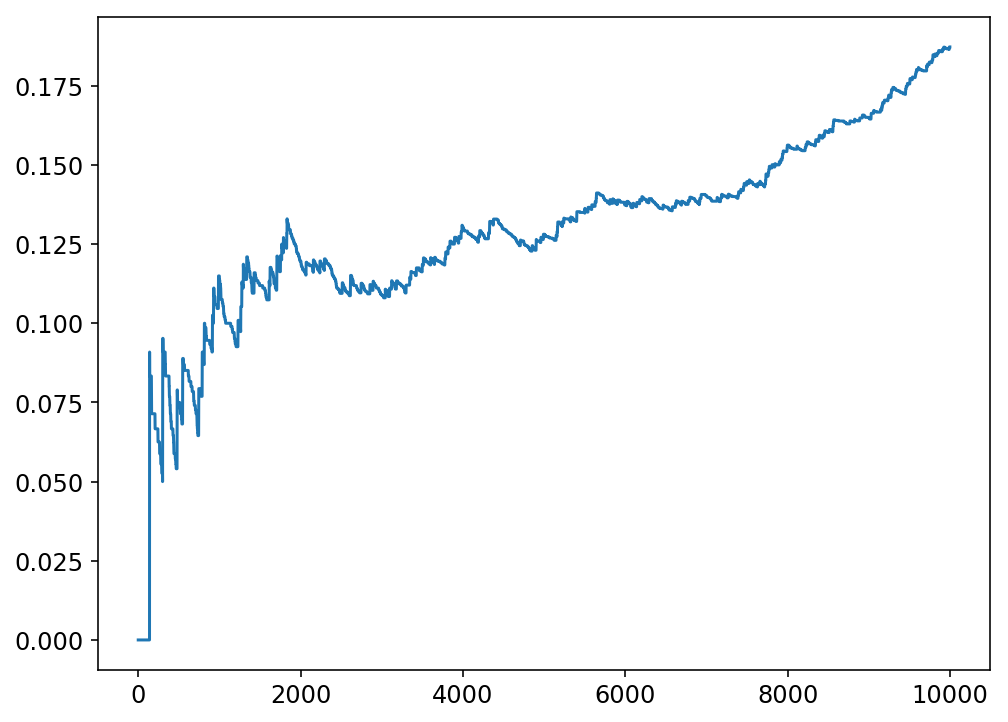

In [11]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

print('arm counts:', replay.policy_.counts_)
plt.plot(ctr_history)
plt.show()

## Direct Method Estimator

In [26]:
class DirectMethodEstimator:
    
    def __init__(self, policy, classifier):
        self.policy = policy
        self.classifier = classifier
        
    def estimate(self, contexts, actions, rewards, fit_params=None):
        policy = self.policy
        classifier = self.classifier
        
        # action column becomes the last column, and is marked as a
        # categorical variable
        data = np.hstack((contexts, actions.reshape(-1, 1)))

        fit_params = {} if fit_params is None else fit_params
        categorical_feature = fit_params.get('categorical_feature', [])
        categorical_feature.append(data.shape[1])
        fit_params['categorical_feature'] = categorical_feature
        classifier.fit(data, rewards, **fit_params)

        cum_reward = 0.0
        valid_events = 0
        ctr_history = []
        n_rows = contexts.shape[0]
        for i in trange(n_rows):
            context = contexts[i]
            action = actions[i]
            chosen_arm = policy.choose_arm(context)

            data_row = np.hstack((context, action)).reshape(1, -1)
            reward = classifier.predict(data_row)[0]
            cum_reward += reward
            valid_events += 1
            policy.update_arm(context, chosen_arm, reward)

            ctr = cum_reward / valid_events
            ctr_history.append(ctr)

        self.policy_ = policy
        self.classifier_ = classifier
        return ctr_history    

In [27]:
lgb = LGBMClassifier(
    n_jobs=-1,
    max_depth=6,
    subsample=1,
    n_estimators=100,
    learning_rate=0.1,
    colsample_bytree=1,
    boosting_type='gbdt',
    importance_type='gain')

direct = DirectMethodEstimator(policy, lgb)
ctr_history = direct.estimate(contexts, actions, rewards)
print('first few records: ', ctr_history[:20])
print('last few records: ', ctr_history[-20:])

/Users/mingyuliu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [101]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
100%|██████████| 10000/10000 [00:46<00:00, 215.95it/s]

first few records:  [0.0, 0.0, 0.0, 0.0, 0.2, 0.16666666666666666, 0.14285714285714285, 0.125, 0.1111111111111111, 0.2, 0.18181818181818182, 0.16666666666666666, 0.15384615384615385, 0.14285714285714285, 0.13333333333333333, 0.1875, 0.17647058823529413, 0.16666666666666666, 0.15789473684210525, 0.15]
last few records:  [0.10379721470794509, 0.10378681626928471, 0.10377641991385356, 0.10376602564102565, 0.10375563345017526, 0.10374524334067695, 0.10373485531190547, 0.10372446936323589, 0.10371408549404344, 0.1037037037037037, 0.10369332399159244, 0.1037830264211369, 0.10377264084859401, 0.10376225735441265, 0.10385192596298148, 0.10384153661464586, 0.10383114934480345, 0.10392078415683137, 0.1039103910391039, 0.1039]


arm counts: [ 758 2495 1232  826  871  959 1687  841 1446  824]


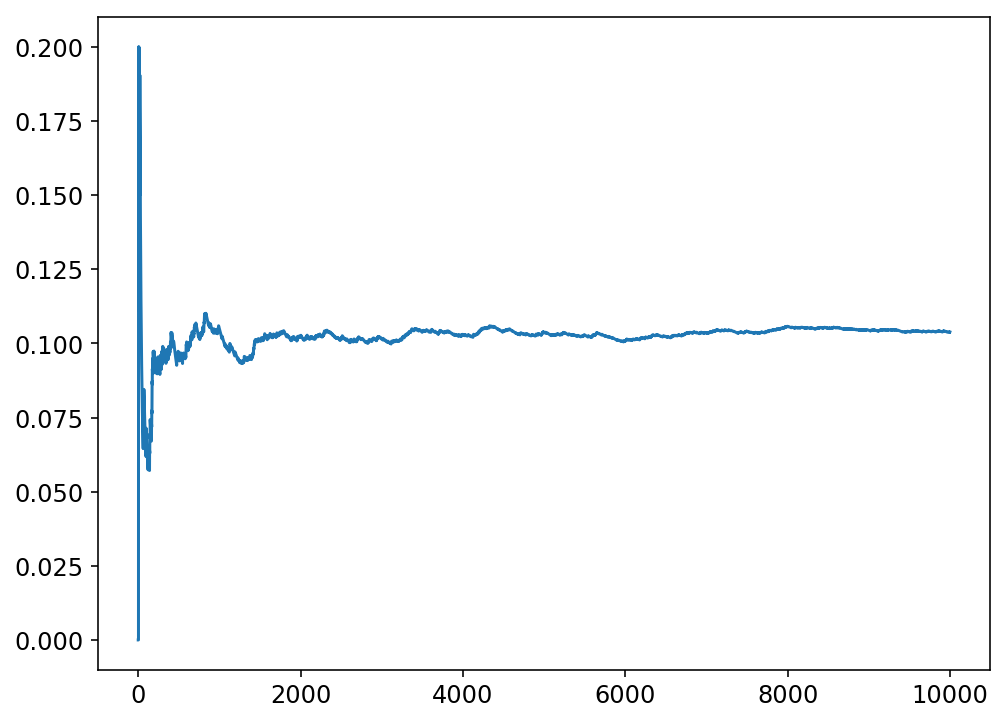

In [28]:
print('arm counts:', direct.policy_.counts_)
plt.plot(ctr_history)
plt.show()

## Inverse Propensity Estimator

In [29]:
class InversePropensityEstimator:
    """

    """
    
    def __init__(self, policy, classifier):
        self.policy = policy
        self.classifier = classifier

    def estimate(self, contexts, actions, rewards, fit_params=None):
        policy = self.policy
        classifier = self.classifier

        fit_params = {} if fit_params is None else fit_params
        classifier.fit(contexts, actions, **fit_params)
        propensity = classifier.predict_proba(contexts)

        n_rows = contexts.shape[0]

        actual_reward = 0.0
        potential_reward = 0
        ctr_history = []

        for i in trange(n_rows):
            context = contexts[i]
            action = actions[i]
            chosen_arm = policy.choose_arm(context)

            if chosen_arm == action:
                reward = rewards[i]
                actual_reward += reward / propensity[i, chosen_arm]
                potential_reward += 1 / propensity[i, chosen_arm]
                policy.update_arm(context, chosen_arm, reward)

            ctr = 0 if potential_reward == 0 else actual_reward / potential_reward
            ctr_history.append(ctr)

        self.policy_ = policy
        self.classifier_ = classifier
        return ctr_history

In [30]:
lgb = LGBMClassifier(
    n_jobs=-1,
    max_depth=6,
    subsample=1,
    n_estimators=100,
    learning_rate=0.1,
    colsample_bytree=1,
    boosting_type='gbdt',
    importance_type='gain')

inverse_propensity = InversePropensityEstimator(policy, lgb)
ctr_history = inverse_propensity.estimate(contexts, actions, rewards)
print('first few records: ', ctr_history[:20])
print('last few records: ', ctr_history[-20:])

100%|██████████| 10000/10000 [00:40<00:00, 244.94it/s]

first few records:  [0, 0, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
last few records:  [0.6561036340566933, 0.6561036340566933, 0.6561036340566933, 0.6561036340566933, 0.6561036340566933, 0.6561036340566933, 0.6561036340566933, 0.6561036340566933, 0.6561036340566933, 0.6561036340566933, 0.6561036340566933, 0.6564926697392622, 0.6564926697392622, 0.6564926697392622, 0.6569618664551788, 0.6569618664551788, 0.6569618664551788, 0.6569618664551788, 0.6569618664551788, 0.6569618664551788]


arm counts: [ 824 2710 1351  905  930 1021 1839  888 1567  880]


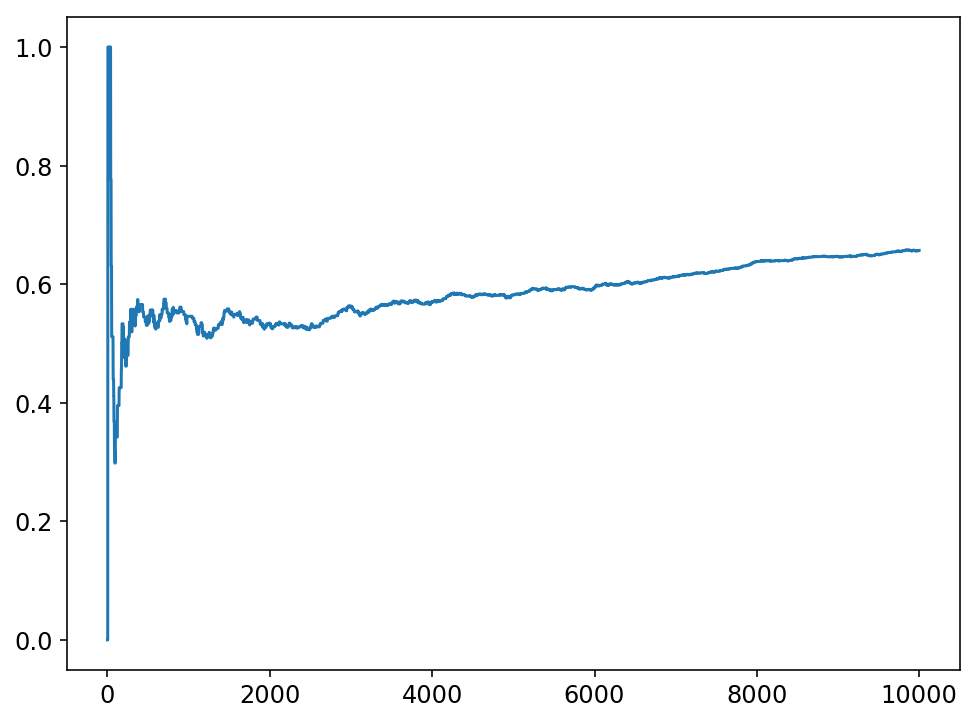

In [31]:
print('arm counts:', inverse_propensity.policy_.counts_)
plt.plot(ctr_history)
plt.show()